<a href="https://colab.research.google.com/github/yenamalavinoothna/Customer-Churn-Prediction/blob/main/Customer_Churn_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from matplotlib import pyplot as plt
import scipy
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from collections import Counter
from imblearn.combine import SMOTEENN
plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Customer Churn/churn_file.csv")
df.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   tenure            7043 non-null   int64  
 2   PhoneService      7043 non-null   object 
 3   Contract          7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   Churn             7043 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


In [ ]:
df.isnull().sum()

customerID          0
tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
df[df.duplicated()].shape[0]

0

In [ ]:
df.dtypes

customerID           object
tenure                int64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
df.drop('customerID',axis=1,inplace=True)

In [ ]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

In [ ]:
df.head(5)

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,34,Yes,One year,No,Mailed check,56.95,1889.50,No
2,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


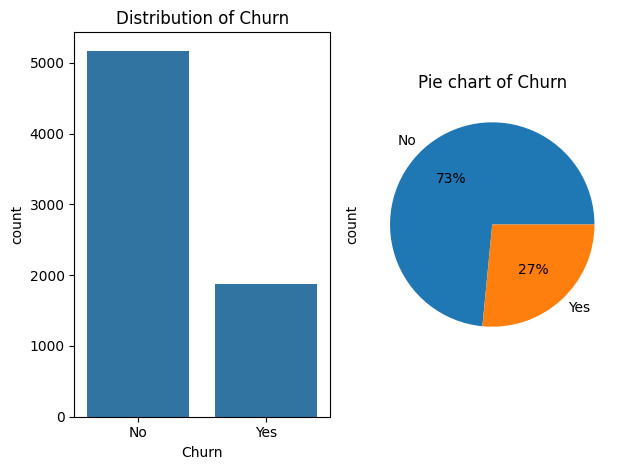

In [ ]:
plt.subplot(121)
sns.countplot(data=df,x="Churn")
plt.title("Distribution of Churn")
plt.subplot(122)
df['Churn'].value_counts().plot(kind='pie',autopct="%1.f%%",labels=['No','Yes'])
plt.title('Pie chart of Churn')
plt.tight_layout()
plt.show()

Since our dataset is highly imbalance we need to balance before fitting it into model

In [ ]:
#how much loss we are having because of customer churn
churn_customers=df[df["Churn"]=="Yes"]
loss=churn_customers["TotalCharges"].sum()
total_revenue=df["TotalCharges"].sum()
print("We have lost arround {}$ due to customer churn".format(loss))
print("We have lost arround {} percentage of revengue due to customer churn".format(np.round(loss/total_revenue*100,decimals=2)))

We have lost arround 2862926.9$ due to customer churn
We have lost arround 17.83 percentage of revengue due to customer churn


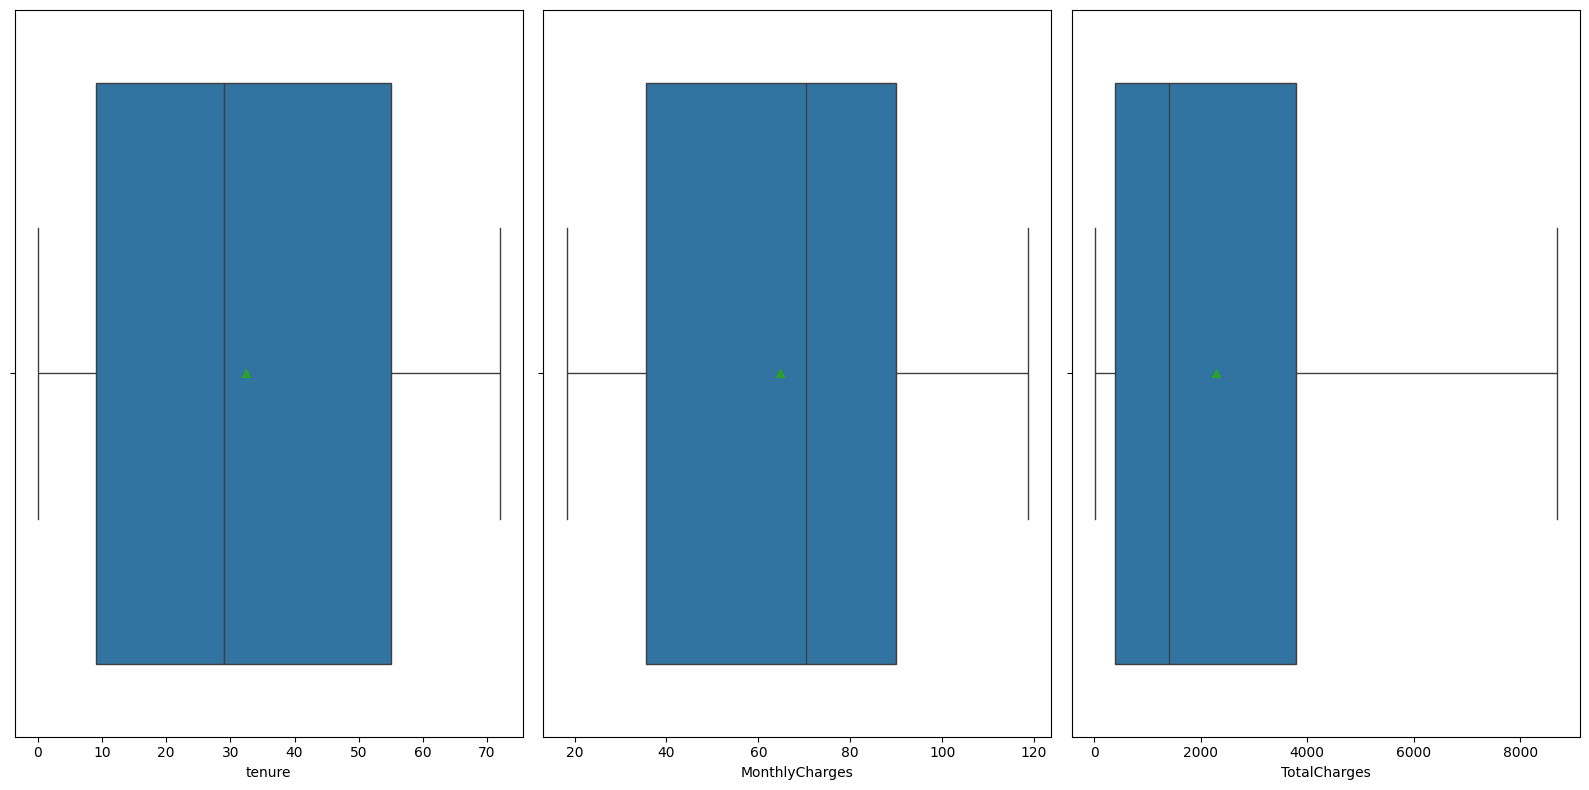

In [ ]:
#plot numerical features with boxplot
fig,axs=plt.subplots(nrows=1,ncols=3,figsize=(16,8))
axes=axs.flatten()
num_columns=['tenure', 'MonthlyCharges', 'TotalCharges']
for i,col in enumerate(num_columns):
    sns.boxplot(x=col,data=df,showmeans=True,ax=axes[i])
fig.tight_layout()
plt.show()

after plotting histogram and boxplot we found that there is no outlier present in numeric dataset so we don't need to do any kind of outlier treatment.

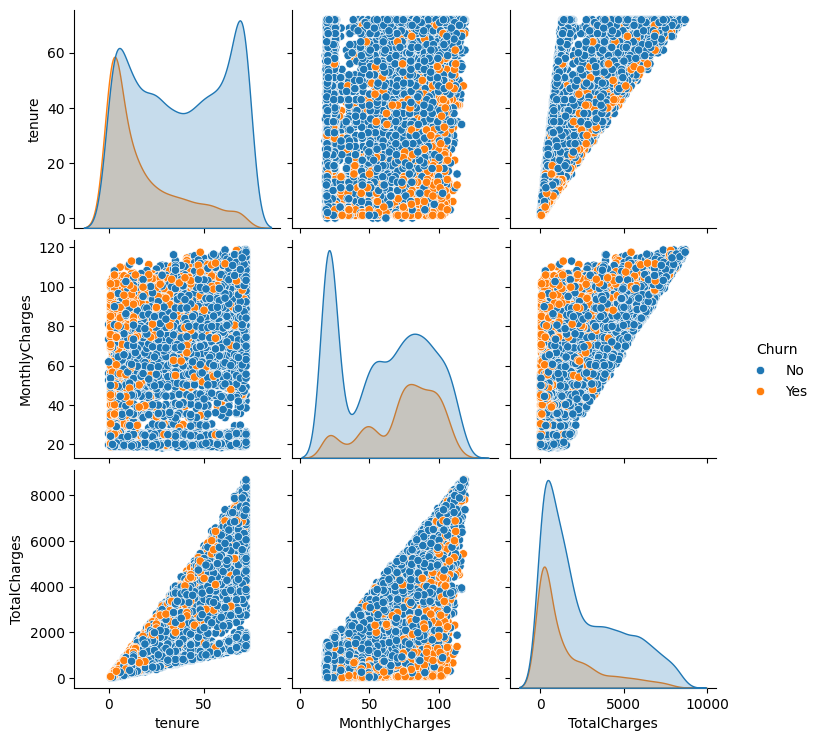

In [ ]:
sns.pairplot(df,hue="Churn",kind="scatter")
plt.show()

Univariate Analysis

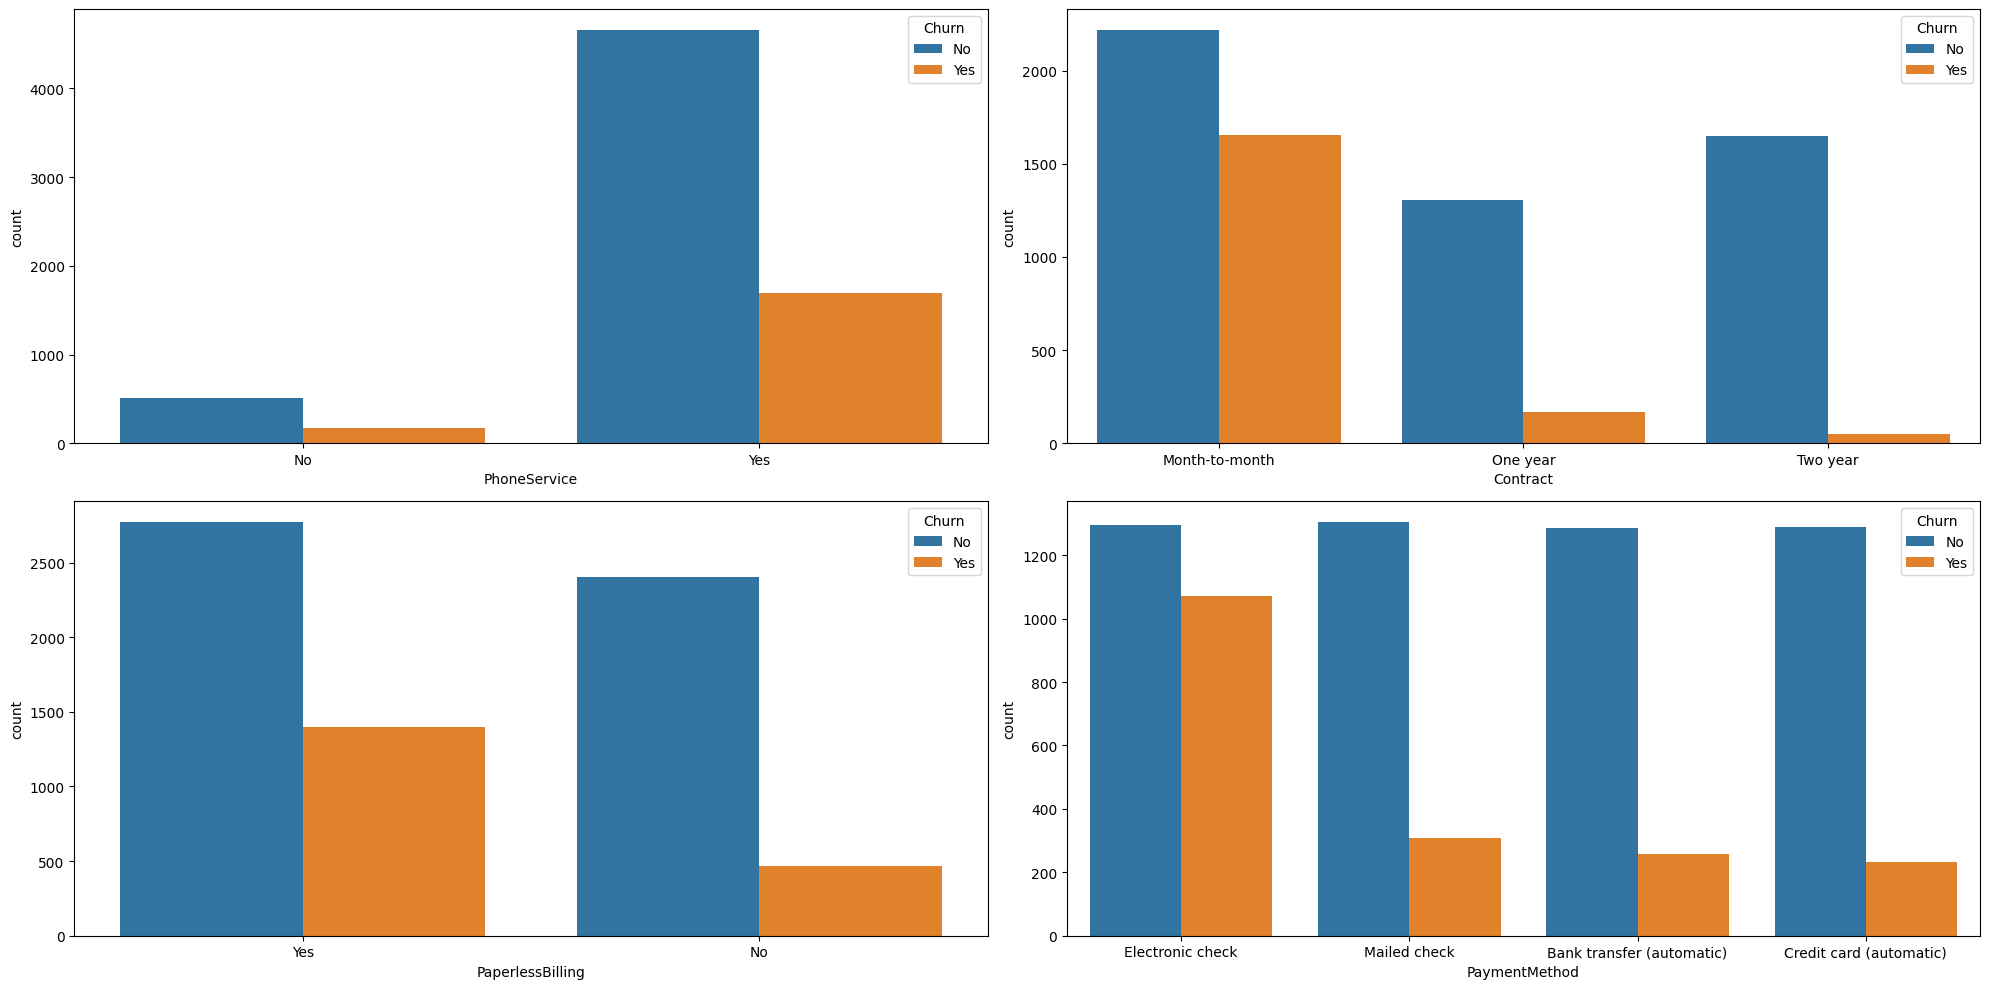

In [ ]:
cat_features=list(df.select_dtypes(include='object').columns)
cat_features.remove('Churn')
#cat_features.append('SeniorCitizen')

fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(20,10))
axes=axs.flatten()
for i,col in enumerate(cat_features):
    sns.countplot(x=col,hue="Churn",data=df,ax=axes[i])
#adjust spacing between subplots
fig.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

tenure               0
PhoneService         0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
df["TotalCharges"].fillna(df["TotalCharges"].mean(),inplace=True)

In [ ]:
df.isnull().sum()

tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
#encoding categorical values into numeric using label encoder
encoder=LabelEncoder()
for feature in df.select_dtypes(include='object').columns:
    df[feature]=encoder.fit_transform(df[feature])

In [ ]:
df.head()

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,2,29.85,29.85,0
1,34,1,1,0,3,56.95,1889.50,0
2,2,1,0,1,3,53.85,108.15,1
3,45,0,1,0,0,42.30,1840.75,0
4,2,1,0,1,2,70.70,151.65,1


In [ ]:
df.dtypes

tenure                int64
PhoneService          int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

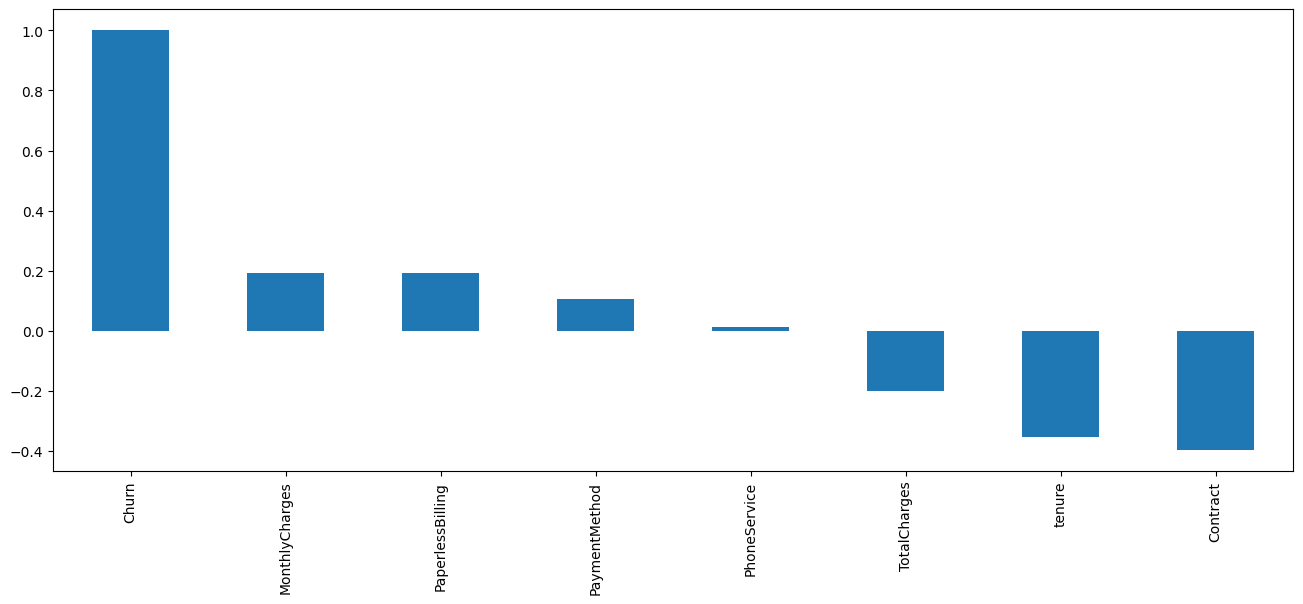

In [ ]:
#get correlation of churn with other variables
plt.figure(figsize=(16,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.show()

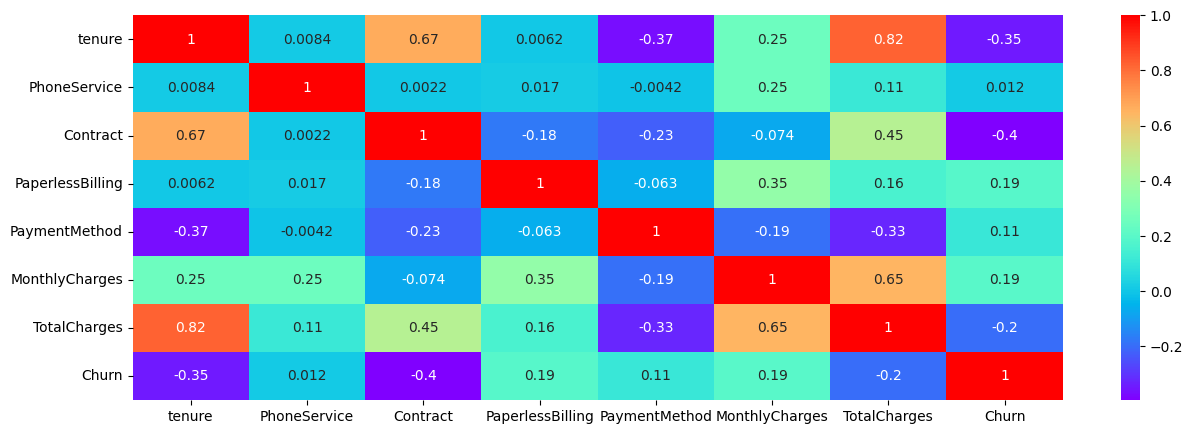

In [ ]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True,cmap="rainbow")
plt.show()

In [ ]:
#seperating independent variables and target variable
x=df.drop("Churn",axis=1)
y=df["Churn"]

In [ ]:
x.shape

(7043, 7)

Feature Selection
selecting only 10 features which has higher correlation with churn



In [ ]:
select_feature=SelectKBest(k=5) #no of features to be select
select_feature.fit(x,y)

SelectKBest(k=5)

In [ ]:
select_feature.get_feature_names_out()

array(['tenure', 'Contract', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges'], dtype=object)

In [ ]:
x=x[select_feature.get_feature_names_out()]

In [ ]:
x.shape

(7043, 5)

according to the feature selection we have selected 5 top features out of 7 features

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((5634, 5), (5634,), (1409, 5), (1409,))

In [ ]:
def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    #print("Training Accurary : ",model.score(x_train,y_train))
    print("Validation Accurary : {:.2f} %".format(accuracy_score(y_test,prediction)))
    print("Precision Score : {:.2f} %".format(precision_score(y_test,prediction)))
    print("Recall Score : {:.2f} %".format(recall_score(y_test,prediction)))
    print("F1 Score : {:.2f} %".format(f1_score(y_test,prediction)))
    print(classification_report(y_test,prediction))

In [ ]:
model_2=LogisticRegression(random_state=0)
model_2.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [ ]:
#measure the performance of random forest model
evaluate_model_performance(model_2,x_test)

Validation Accurary : 0.80 %
Precision Score : 0.64 %
Recall Score : 0.58 %
F1 Score : 0.61 %
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1036
           1       0.64      0.58      0.61       373

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



as we can see our model is not performing up to the mark because of imbalance nature of dataset so we will balance it to reduce TN,FN and increase TP,FP

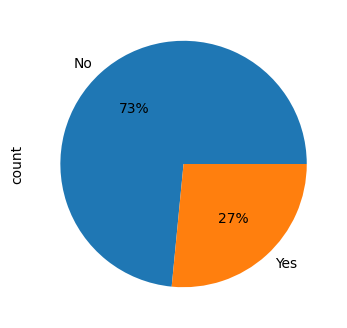

In [ ]:
plt.figure(figsize=(8,4))
y.value_counts().plot(kind="pie",autopct="%1.f%%",labels=['No','Yes'])
plt.show()

we have 2 classes class 0 and class 1. class 0 - majority class class 1 -minority class

In [ ]:
smote=SMOTEENN()
x_st,y_st=smote.fit_resample(x,y)

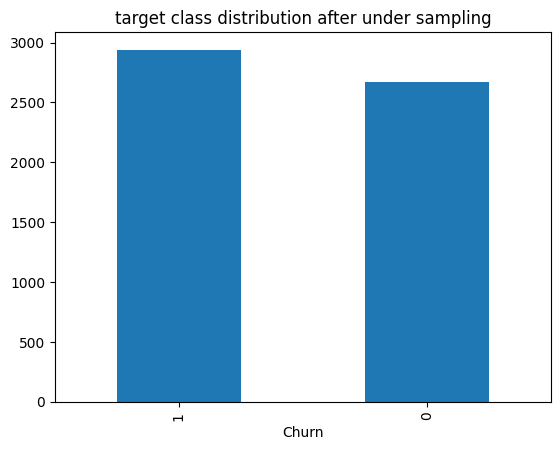

In [ ]:
y_st.value_counts().plot(kind="bar")
plt.title("target class distribution after under sampling")
plt.show()

In [ ]:
y_st.value_counts()

Churn
1    2939
0    2668
Name: count, dtype: int64

since we have performed SMOTEENN (combination of Smote + ENN) sampling method and we can see our dataset is nearly balanced

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_st,y_st,test_size=0.2,random_state=42)

In [ ]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((4485, 5), (4485,), (1122, 5), (1122,))

Building Model with Balanced Dataset and performance hyper parameter tuning using RandomSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid={
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty type
    'solver': ['liblinear', 'saga']  # Solver algorithm
            }
logistic = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=logistic, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)
test_score = grid_search.score(x_test, y_test)
print(test_score)

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.9146042363433668
0.9144385026737968


In [ ]:
lr_final_model=grid_search.best_estimator_

In [ ]:
evaluate_model_performance(lr_final_model,x_test)

Validation Accurary : 0.91 %
Precision Score : 0.89 %
Recall Score : 0.94 %
F1 Score : 0.92 %
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       554
           1       0.89      0.94      0.92       568

    accuracy                           0.91      1122
   macro avg       0.92      0.91      0.91      1122
weighted avg       0.92      0.91      0.91      1122



In [ ]:
file=open("trained_model.pkl","wb")
pickle.dump(lr_final_model,file)
file.close()